In [1]:
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [2]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use('ggplot')


In [3]:
pytrends = TrendReq(hl='en-US', tz=360)

In [4]:
kw_list = ['job']
pytrends.build_payload(kw_list, cat=0, timeframe='2005-01-01 2018-12-31', geo='US', gprop='')

In [5]:
df_job = pytrends.interest_over_time()

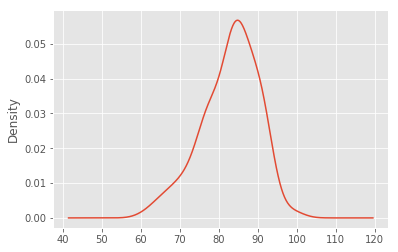

In [6]:
df_job.job.plot.kde()

In [147]:
len(df_job)

168

In [8]:
df_job.drop("isPartial",inplace=True,axis=1)

In [9]:
df_job_array = df_job.values

In [10]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [11]:
df_supervised = timeseries_to_supervised(df_job)

In [12]:
# stationarize data
def return_seasonal_decomp(data):
    decomposition = seasonal_decompose(data)

    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(data, label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout()
    return decomposition

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


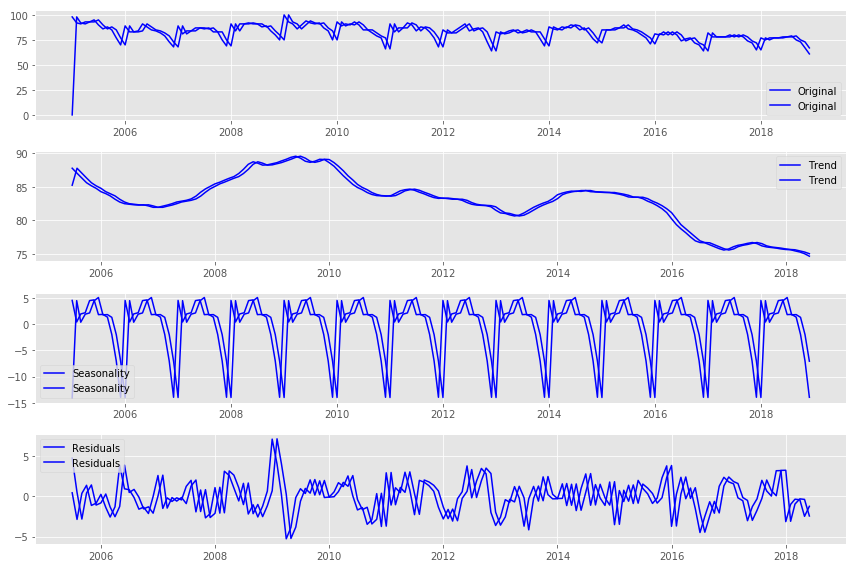

In [13]:
df_stat = return_seasonal_decomp(df_supervised)

In [14]:
df_resid = df_stat.resid.dropna()

In [17]:
#reverse MinMaxScaling
# inverted_X = scaler.inverse_transform(df_resid_scaled)

In [168]:
df_job.head()

,job
date,
2005-01-01,98
2005-02-01,92
2005-03-01,91
2005-04-01,93
2005-05-01,93


1) Test RMSE: 12.905
2) Test RMSE: 12.941
3) Test RMSE: 13.063
4) Test RMSE: 12.914
5) Test RMSE: 13.008
6) Test RMSE: 12.848
7) Test RMSE: 12.905
8) Test RMSE: 12.948
9) Test RMSE: 12.866
10) Test RMSE: 13.060
11) Test RMSE: 13.541
12) Test RMSE: 12.928
13) Test RMSE: 12.921
14) Test RMSE: 13.050
15) Test RMSE: 12.894
16) Test RMSE: 12.947
17) Test RMSE: 12.852
18) Test RMSE: 12.944
19) Test RMSE: 12.848
20) Test RMSE: 12.861
21) Test RMSE: 13.109
22) Test RMSE: 12.867
23) Test RMSE: 13.007
24) Test RMSE: 12.962
25) Test RMSE: 12.870
26) Test RMSE: 13.732
27) Test RMSE: 12.970
28) Test RMSE: 12.925
29) Test RMSE: 12.939
30) Test RMSE: 12.986
            rmse
count  30.000000
mean   12.987033
std     0.190977
min    12.848120
25%    12.896514
50%    12.939677
75%    13.001618
max    13.732368


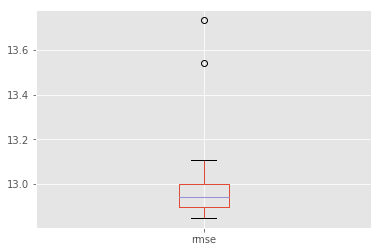

In [157]:
# Full Code -- This 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from math import sqrt
from matplotlib import pyplot
import numpy

# Load Dataset

# Convert to supervised learning problem
def timeseries_to_supervised(pd_series, lag=1):
    df = pd_series.dropna()
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# Stationarize data
def difference(data):
    decomposition = seasonal_decompose(data)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    return decomposition

# Undo Stationarization
def invert_difference(history, yhat, upper=1):
    lower = upper - 1
    trend = history.trend.dropna().iloc[lower:upper,:]['job']
    seasonal = diff_values.seasonal.dropna().iloc[6:,:].iloc[lower:upper,:]['job']
    return yhat + seasonal + trend

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1,activation="tanh"))
    model.compile(loss='mse', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# load dataset
series = df_job

# transform data to be stationary
raw_values = series['job'].values
diff_values = difference(series)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values.resid.job, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 300, 6)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = invert_difference(diff_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

In [ ]:
# Begin Single Walk Forward Validation

# fit the model
# lstm_model = fit_lstm(train_scaled, 1, 100, 6)

# # forecast the entire training dataset to build up state for forecasting
# train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
# lstm_model.predict(train_reshaped, batch_size=1)


# # walk-forward validation on the test data
# predictions = list()
# for i in range(len(test_scaled)):
#     # make one-step forecast
#     X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
#     yhat = forecast_lstm(lstm_model, 1, X)
#     # invert scaling
#     yhat = invert_scale(scaler, X, yhat)
#     # invert differencing
#     yhat = invert_difference(diff_values, yhat, len(test_scaled)+1-i)
#     # store forecast
#     predictions.append(yhat)
#     expected = raw_values[len(train) + i + 1]
#     print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# # report performance
# rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
# print('Test RMSE: %.3f' % rmse)
# # line plot of observed vs predicted
# pyplot.plot(raw_values[-12:])
# pyplot.plot(predictions)
# pyplot.show()

In [158]:
def invert_difference(history, yhat, upper=1):
    lower = upper - 1
    trend = history.trend.dropna().iloc[lower:upper,:]['job']
    seasonal = diff_values.seasonal.dropna().iloc[6:,:].iloc[lower:upper,:]['job']
    return yhat + seasonal + trend
#     return yhat + history.trend.dropna().iloc[lower:upper,:]["job"] + history.seasonal.dropna().iloc[lower:upper,:]["job"]

In [159]:
yhat = forecast_lstm(lstm_model, 1, X)
yhat = invert_scale(scaler, X, yhat)
yhat = invert_difference(diff_values, yhat, len(test_scaled)+1-i)

yhat

date
2005-08-01    89.080075
Name: job, dtype: float64

            rmse
count  30.000000
mean   12.987033
std     0.190977
min    12.848120
25%    12.896514
50%    12.939677
75%    13.001618
max    13.732368


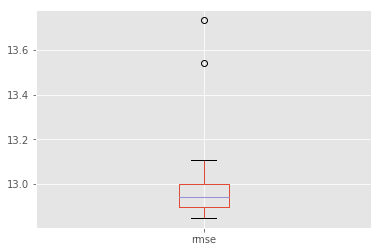

In [161]:
# summarize results -- Test #1 1 batch; 100 epochs; 6 Neurons; repeated 30 times
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

In [178]:
### Unemployment LSTM
df = pd.read_excel('dash_package/BLS_SA_Unemployment.xlsx',header=3)
ts_df = df.transpose()
df_UE = ts_df.iloc[1:]
df_UE.columns = ["unemployment_rate"]
date_rng = pd.date_range(start='1/1/1948', end='12/31/2018', freq='MS')
df_UE.index = date_rng
df_UE = pd.DataFrame(pd.to_numeric(df_UE.iloc[:,0],"float"))
df_UE = df_UE["2005-01-01":]

In [180]:
df_UE.dtypes

unemployment_rate    float64
dtype: object

In [187]:
from sklearn.utils import check_array

1) Test RMSE: 0.932
2) Test RMSE: 0.936
3) Test RMSE: 0.932
4) Test RMSE: 0.926
5) Test RMSE: 0.910
6) Test RMSE: 0.889
7) Test RMSE: 0.929
8) Test RMSE: 0.932
9) Test RMSE: 0.923
10) Test RMSE: 0.913
11) Test RMSE: 0.936
12) Test RMSE: 0.912
13) Test RMSE: 0.928
14) Test RMSE: 0.910
15) Test RMSE: 0.933
16) Test RMSE: 0.919
17) Test RMSE: 0.932
18) Test RMSE: 0.918
19) Test RMSE: 0.927
20) Test RMSE: 0.925
21) Test RMSE: 0.935
22) Test RMSE: 0.931
23) Test RMSE: 0.928
24) Test RMSE: 0.929
25) Test RMSE: 0.937
26) Test RMSE: 0.930
27) Test RMSE: 0.922
28) Test RMSE: 0.934
29) Test RMSE: 0.950
30) Test RMSE: 0.937
            rmse
count  30.000000
mean    0.926494
std     0.011417
min     0.889166
25%     0.922482
50%     0.929231
75%     0.932606
max     0.949743


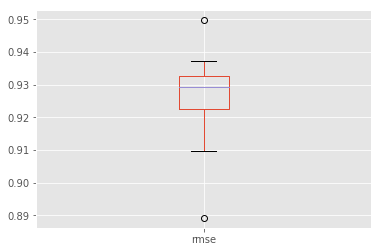

In [194]:
# Full Code 
from sklearn.utils import check_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from math import sqrt
from matplotlib import pyplot
import numpy

# Load Dataset

# Convert to supervised learning problem
def timeseries_to_supervised(pd_series, lag=1):
    df = pd_series.dropna()
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# Stationarize data
def difference(data):
    decomposition = seasonal_decompose(data)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    return decomposition

# Undo Stationarization
def invert_difference(history, yhat, upper=1):
    lower = upper - 1
    trend = history.trend.dropna().iloc[lower:upper,:]['unemployment_rate']
    seasonal = diff_values.seasonal.dropna().iloc[6:,:].iloc[lower:upper,:]['unemployment_rate']
    return yhat + seasonal + trend

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1,activation="tanh"))
    model.compile(loss='mse', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_array(y_true, y_pred)

#     # Note: does not handle mix 1d representation
#     if _is_1d(y_true): 
#         y_true, y_pred = _check_1d_array(y_true, y_pred)

#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# load dataset
series = df_UE

# transform data to be stationary
raw_values = series['unemployment_rate'].values
diff_values = difference(series)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values.resid.unemployment_rate, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 30
error_scores = list()
mape_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 300, 6)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = invert_difference(diff_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
    
    
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()